<a href="https://colab.research.google.com/github/sachaRfd/Name-Classification-Algorithm/blob/main/Copy_of_Name_Classification_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name Classification Algorithm: Adapted from https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

Prepping Data from Local File: 
- Helper Functions to switch Names with extra symbols to ACSII names
- Get dictionary of names where the class is the country the names belong to.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/German.txt', 'data/names/Russian.txt', 'data/names/English.txt', 'data/names/Polish.txt', 'data/names/Vietnamese.txt', 'data/names/Italian.txt', 'data/names/French.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt', 'data/names/Scottish.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/Portuguese.txt', 'data/names/Korean.txt', 'data/names/Dutch.txt']
Slusarski


In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning the names to tensors: 
- Then One Hot Encoding them so the model can interpret it

In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


The Model: 

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8602, -2.9925, -2.9192, -2.9859, -2.7974, -2.8451, -2.8387, -2.9213,
         -2.9808, -2.8548, -2.9524, -2.9131, -2.7923, -2.9088, -2.8854, -2.8891,
         -2.8592, -2.8608]], grad_fn=<LogSoftmaxBackward0>)


Log-Likelyhood of being from that category --> The Higher the better

Training: 
- Helper Functions: 
  - Interpret output of the network: Get from the index of highest log-likelihood to the Category name --> can just use Tensor.topk to get index of highest value then convert it to its category
  - 

In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 12)


Quick Training Example: 


In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = Naomhan
category = Vietnamese / line = Do
category = Japanese / line = Uboshita
category = Czech / line = Mozzis
category = Scottish / line = Anderson
category = Japanese / line = Kimio
category = Chinese / line = Xuan
category = Scottish / line = Smith
category = Chinese / line = Wang
category = Chinese / line = Hong


Now we can get to training: 
- No need for batches
- We will be using the NLLLoss function as last layer of RNN is logsoftmax()

In [10]:
criterion = nn.NLLLoss()

The training loop will consist of: 
- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
  - Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [11]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()  # instanciate the Hidden Unit

    rnn.zero_grad()  # Set zero gradient

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)  # Run model

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss

In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 14s) 2.6883 Samson / Scottish ✗ (Dutch)
10000 10% (0m 20s) 2.9839 Magalhaes / Japanese ✗ (Portuguese)
15000 15% (0m 26s) 2.3238 Bruce / French ✗ (Scottish)
20000 20% (0m 32s) 2.1890 Bonomo / Arabic ✗ (Italian)
25000 25% (0m 37s) 0.8782 Piraino / Italian ✓
30000 30% (0m 44s) 1.0172 Gronchi / Italian ✓
35000 35% (0m 50s) 3.2497 Roig / Korean ✗ (Spanish)
40000 40% (0m 56s) 0.6295 Gomulka / Polish ✓
45000 45% (1m 2s) 0.1758 Sklavenitis / Greek ✓
50000 50% (1m 8s) 0.3560 Slapnickova / Czech ✓
55000 55% (1m 14s) 1.7684 Vicario / Portuguese ✗ (Italian)
60000 60% (1m 20s) 0.2990 Pechinkin / Russian ✓
65000 65% (1m 25s) 2.0037 Fabron / Scottish ✗ (French)
70000 70% (1m 31s) 1.8333 Kenning / English ✓
75000 75% (1m 37s) 0.7374 Kloeten / Dutch ✓
80000 80% (1m 43s) 1.4176 Desjardins / French ✓
85000 85% (1m 51s) 0.7684 Viola / Spanish ✓
90000 90% (1m 58s) 1.2416 Lorentz / German ✓
95000 95% (2m 4s) 0.2101 Delacroix / French ✓
100000 100% (2m 10s) 0.5302 Ho / Vietnamese ✓


We can also plot the learning curve of the model: 

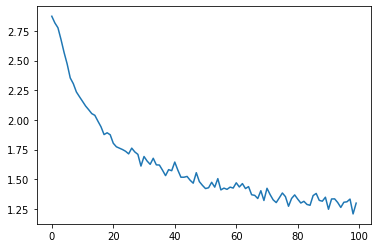

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluation of the Model: 

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

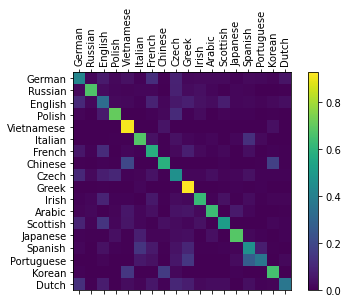

In [17]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show();

You can see that the model confuses certain languages together such as Korean and Chinese and Spanish and Portuguese.

Function to get user Input: 

In [35]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Raffaud')  # French
predict('Linh Lou')  # Vietnamese
predict('Auquier')  # French
predict('Atash')  


> Raffaud
(-1.44) French
(-2.10) English
(-2.20) Arabic

> Linh Lou
(-0.49) Vietnamese
(-1.31) Korean
(-2.39) Chinese

> Auquier
(-0.79) French
(-1.95) Dutch
(-2.12) German

> Atash
(-0.09) Arabic
(-3.64) German
(-4.33) Japanese
